In [1]:
import numpy as np
import pandas as pd
import os
import gc
import json
from joblib import dump, load
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

## Configuration

In [2]:
# Path where the data is stored
SOURCE_PATH = '../../../data'
# Directory inside SOURCE_PATH where the derived data is stored
DERIVED_DATA_DIR = '/derived_data'
# Experiment params
DATE_EXPERIMENT = '24022021'

# Number of force cells in the robotic leg
N_CELLS = 8

# Experiment params
DATA_ID = '0002_31032021'

print('Model training with data: ' + DATA_ID)

Model training with data: 0002_31032021


## Load data

In [3]:
# Load data
X_train = np.load(os.path.join(SOURCE_PATH + DERIVED_DATA_DIR, DATE_EXPERIMENT, 'X_train_' + DATA_ID + '.npy'))
X_test = np.load(os.path.join(SOURCE_PATH + DERIVED_DATA_DIR, DATE_EXPERIMENT, 'X_test_' + DATA_ID + '.npy'))
Y_train = np.load(os.path.join(SOURCE_PATH + DERIVED_DATA_DIR, DATE_EXPERIMENT, 'Y_train_' + DATA_ID + '.npy'))
Y_test = np.load(os.path.join(SOURCE_PATH + DERIVED_DATA_DIR, DATE_EXPERIMENT, 'Y_test_' + DATA_ID + '.npy'))

print('X train: {}, Y train: {}'.format(X_train.shape, Y_train.shape))
print('X test: {}, Y test: {}'.format(X_test.shape, Y_test.shape))

X train: (187982, 15), Y train: (187982, 24)
X test: (80564, 15), Y test: (80564, 24)


In [4]:
# Load model
model = load(os.path.join(SOURCE_PATH + DERIVED_DATA_DIR, DATE_EXPERIMENT, 'model_' + DATA_ID + '.joblib'))

## Feature selection

In [5]:
# Analyze the features importance for the trained model
H3_LEG = 'L' # L|R
features = [H3_LEG + a + m for a in ['Hip', 'Knee', 'Ankle'] for m in ['Pos', 'Vel', 'Acc', 'Torque']] + ['LegKnee{}Filtered'.format(m) for m in ['Position', 'Velocity', 'Torque']]

feature_importances = pd.DataFrame({'feature': features, 
                                    'importance': model.feature_importances_}
                                  ).sort_values('importance', ascending=False)

feature_importances

,feature,importance
14,LegKneeTorqueFiltered,0.245472
0,LHipPos,0.148443
12,LegKneePositionFiltered,0.120479
13,LegKneeVelocityFiltered,0.073196
11,LAnkleTorque,0.060552
4,LKneePos,0.053116
7,LKneeTorque,0.049887
2,LHipAcc,0.048245
3,LHipTorque,0.037815
6,LKneeAcc,0.037010


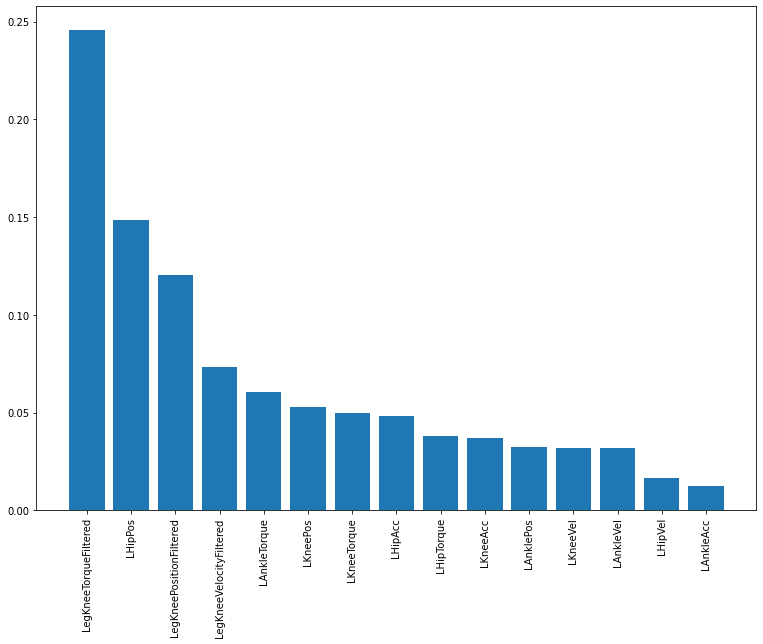

In [6]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_axes([0,0,1,1])
ax.bar(feature_importances['feature'], feature_importances['importance'])
plt.xticks(rotation=90)
plt.show()

In [25]:
def sum_up_scores(scores_dict, Y_train, train_preds, Y_test, test_preds, n_cells):
    '''
    Sum up all the scores for each target in a dictionay with the mean value and the
    standard deviation of the scores per force axis.
    
    Args:
    - scores_dict (dict): Dictionary with all the relevant metrics
    - Y_train (np.ndarray): True labels of the training set.
    - train_preds (np.ndarray): Label predictions of the training set.
    - Y_train (np.ndarray): True labels of the test set.
    - train_preds (np.ndarray): Label predictions of the test set.
    - n_cells (int): Number of force cells.
    
    Returns:
    - scores_dict (dict): Dictionary with all the relevant metrics
    '''   
    train_mae = mean_absolute_error(Y_train, train_preds, multioutput='raw_values')
    train_mae_x = [train_mae[i] for i in range(0, n_cells * 3, 3)]  
    train_mae_y = [train_mae[i] for i in range(1, n_cells * 3, 3)]  
    train_mae_z = [train_mae[i] for i in range(2, n_cells * 3, 3)]  
    
    train_mse = mean_squared_error(Y_train, train_preds, multioutput='raw_values')
    train_mse_x = [train_mse[i] for i in range(0, n_cells * 3, 3)]  
    train_mse_y = [train_mse[i] for i in range(1, n_cells * 3, 3)]  
    train_mse_z = [train_mse[i] for i in range(2, n_cells * 3, 3)]
    
    train_r2 = r2_score(Y_train, train_preds, multioutput='raw_values')
    train_r2_x = [train_r2[i] for i in range(0, n_cells * 3, 3)]  
    train_r2_y = [train_r2[i] for i in range(1, n_cells * 3, 3)]  
    train_r2_z = [train_r2[i] for i in range(2, n_cells * 3, 3)]
    
    test_mae = mean_absolute_error(Y_test, test_preds, multioutput='raw_values')
    test_mae_x = [test_mae[i] for i in range(0, n_cells * 3, 3)]  
    test_mae_y = [test_mae[i] for i in range(1, n_cells * 3, 3)]  
    test_mae_z = [test_mae[i] for i in range(2, n_cells * 3, 3)]  
    
    test_mse = mean_squared_error(Y_test, test_preds, multioutput='raw_values')
    test_mse_x = [test_mse[i] for i in range(0, n_cells * 3, 3)]  
    test_mse_y = [test_mse[i] for i in range(1, n_cells * 3, 3)]  
    test_mse_z = [test_mse[i] for i in range(2, n_cells * 3, 3)]  
    
    test_r2 = r2_score(Y_test, test_preds, multioutput='raw_values')
    test_r2_x = [test_r2[i] for i in range(0, n_cells * 3, 3)]  
    test_r2_y = [test_r2[i] for i in range(1, n_cells * 3, 3)]  
    test_r2_z = [test_r2[i] for i in range(2, n_cells * 3, 3)]  
    
    # Store the results
    scores_dict['train']['MAE']['X_mean'].append(np.mean(train_mae_x))
    scores_dict['train']['MAE']['X_std'].append(np.std(train_mae_x))
    scores_dict['train']['MAE']['Y_mean'].append(np.mean(train_mae_y))
    scores_dict['train']['MAE']['Y_std'].append(np.std(train_mae_y))
    scores_dict['train']['MAE']['Z_mean'].append(np.mean(train_mae_z))
    scores_dict['train']['MAE']['Z_std'].append(np.std(train_mae_z))
    
    scores_dict['train']['MSE']['X_mean'].append(np.mean(train_mse_x))
    scores_dict['train']['MSE']['X_std'].append(np.std(train_mse_x))
    scores_dict['train']['MSE']['Y_mean'].append(np.mean(train_mse_y))
    scores_dict['train']['MSE']['Y_std'].append(np.std(train_mse_y))
    scores_dict['train']['MSE']['Z_mean'].append(np.mean(train_mse_z))
    scores_dict['train']['MSE']['Z_std'].append(np.std(train_mse_z))
    
    scores_dict['train']['R2']['X_mean'].append(np.mean(train_r2_x))
    scores_dict['train']['R2']['X_std'].append(np.std(train_r2_x))
    scores_dict['train']['R2']['Y_mean'].append(np.mean(train_r2_y))
    scores_dict['train']['R2']['Y_std'].append(np.std(train_r2_y))
    scores_dict['train']['R2']['Z_mean'].append(np.mean(train_r2_z))
    scores_dict['train']['R2']['Z_std'].append(np.std(train_r2_z))
    
    scores_dict['test']['MAE']['X_mean'].append(np.mean(test_mae_x))
    scores_dict['test']['MAE']['X_std'].append(np.std(test_mae_x))
    scores_dict['test']['MAE']['Y_mean'].append(np.mean(test_mae_y))
    scores_dict['test']['MAE']['Y_std'].append(np.std(test_mae_y))
    scores_dict['test']['MAE']['Z_mean'].append(np.mean(test_mae_z))
    scores_dict['test']['MAE']['Z_std'].append(np.std(test_mae_z))
    
    scores_dict['test']['MSE']['X_mean'].append(np.mean(test_mse_x))
    scores_dict['test']['MSE']['X_std'].append(np.std(test_mse_x))
    scores_dict['test']['MSE']['Y_mean'].append(np.mean(test_mse_y))
    scores_dict['test']['MSE']['Y_std'].append(np.std(test_mse_y))
    scores_dict['test']['MSE']['Z_mean'].append(np.mean(test_mse_z))
    scores_dict['test']['MSE']['Z_std'].append(np.std(test_mse_z))
    
    scores_dict['test']['R2']['X_mean'].append(np.mean(test_r2_x))
    scores_dict['test']['R2']['X_std'].append(np.std(test_r2_x))
    scores_dict['test']['R2']['Y_mean'].append(np.mean(test_r2_y))
    scores_dict['test']['R2']['Y_std'].append(np.std(test_r2_y))
    scores_dict['test']['R2']['Z_mean'].append(np.mean(test_r2_z))
    scores_dict['test']['R2']['Z_std'].append(np.std(test_r2_z))
    
    return scores_dict

In [8]:
# Remove features one by one to visualize the impact in the scores
feature_importance_idx = np.absolute(model.feature_importances_).argsort()[::-1]

scores_dict = {
        'train':{
            'MAE': {'X_mean': [], 'X_std': [], 'Y_mean': [], 'Y_std': [], 'Z_mean': [], 'Z_std': []},
            'MSE': {'X_mean': [], 'X_std': [], 'Y_mean': [], 'Y_std': [], 'Z_mean': [], 'Z_std': []},
            'R2': {'X_mean': [], 'X_std': [], 'Y_mean': [], 'Y_std': [], 'Z_mean': [], 'Z_std': []}
        },
        'test':{
            'MAE': {'X_mean': [], 'X_std': [], 'Y_mean': [], 'Y_std': [], 'Z_mean': [], 'Z_std': []},
            'MSE': {'X_mean': [], 'X_std': [], 'Y_mean': [], 'Y_std': [], 'Z_mean': [], 'Z_std': []},
            'R2': {'X_mean': [], 'X_std': [], 'Y_mean': [], 'Y_std': [], 'Z_mean': [], 'Z_std': []}
        }
    }

for f in tqdm(range(len(feature_importances), 0, -1)):
    # Select the index of the features to use
    fi_idx = feature_importance_idx[:f]
    
    # Define and train the model
    model_fs = RandomForestRegressor(random_state=0, verbose=0)
    model_fs.fit(X_train[:, fi_idx], Y_train)
    
    # Predict the target for each subset and get its scores
    train_preds = model_fs.predict(X_train[:, fi_idx])
    test_preds = model_fs.predict(X_test[:, fi_idx])
    
    scores_dict = sum_up_scores(scores_dict, Y_train, train_preds, Y_test, Y_test, test_preds, N_CELLS)
    
    del model_fs
    gc.collect()
    
# Save the scores
json.dump(scores_dict, open('./logs/scores_fs_{}.json'.format(DATA_ID), 'w'))

100%|██████████| 15/15 [1:34:23<00:00, 377.54s/it] 


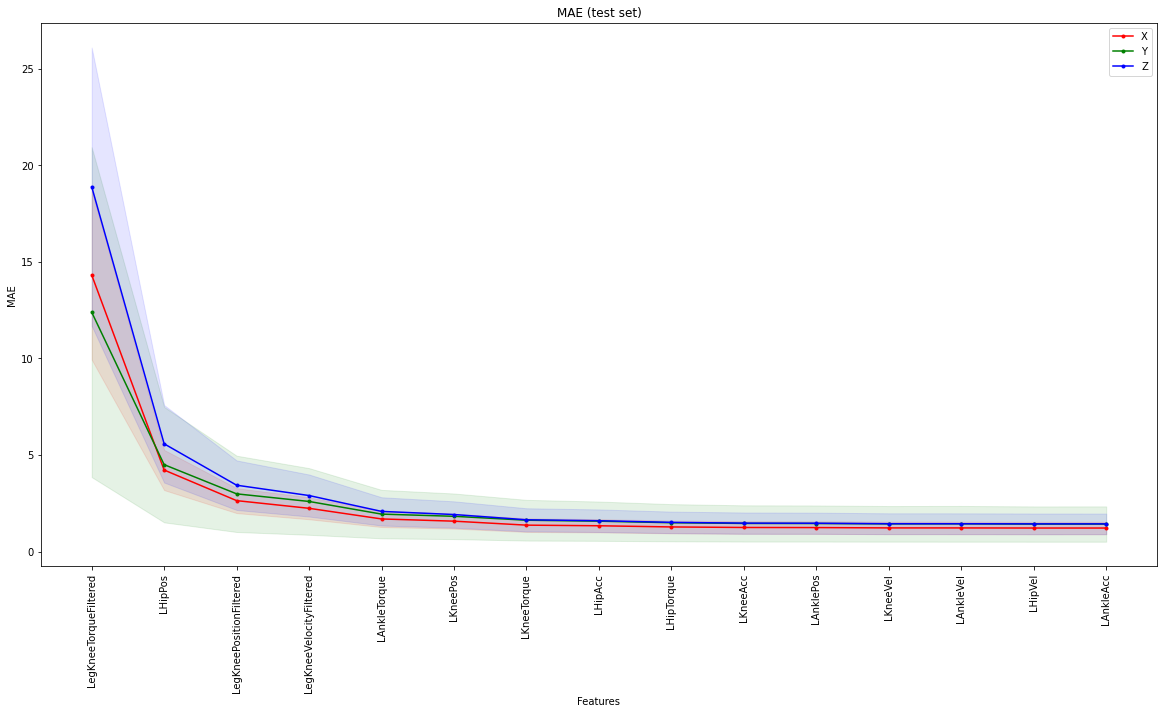

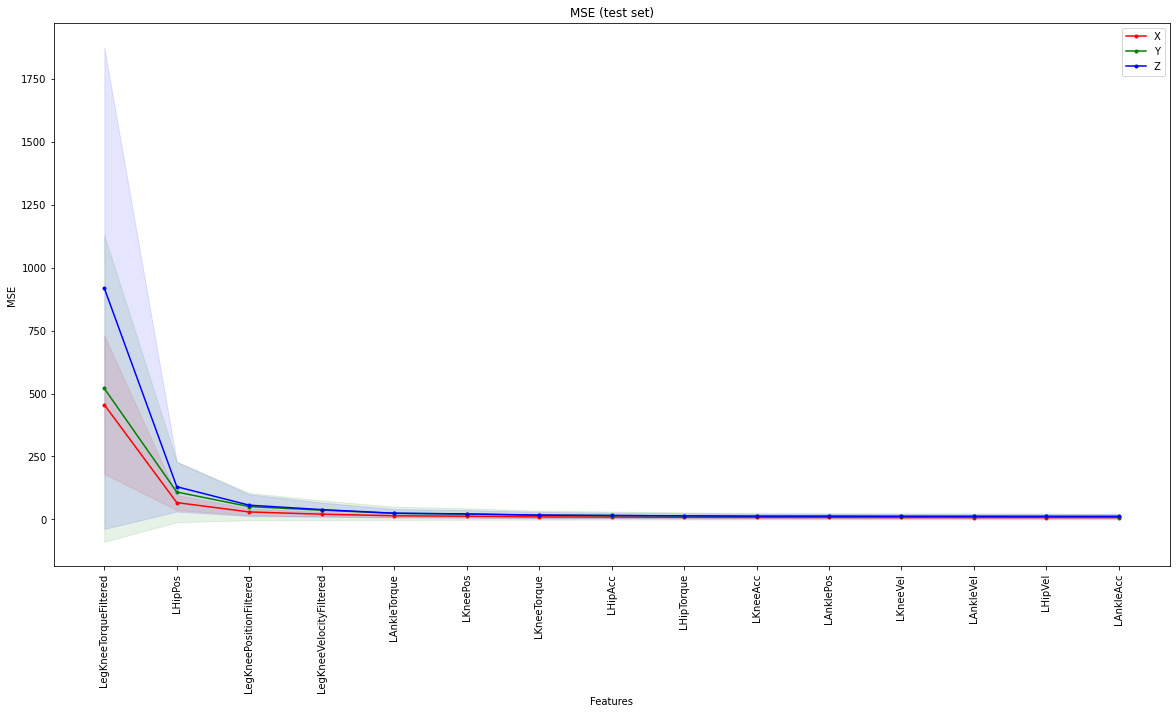

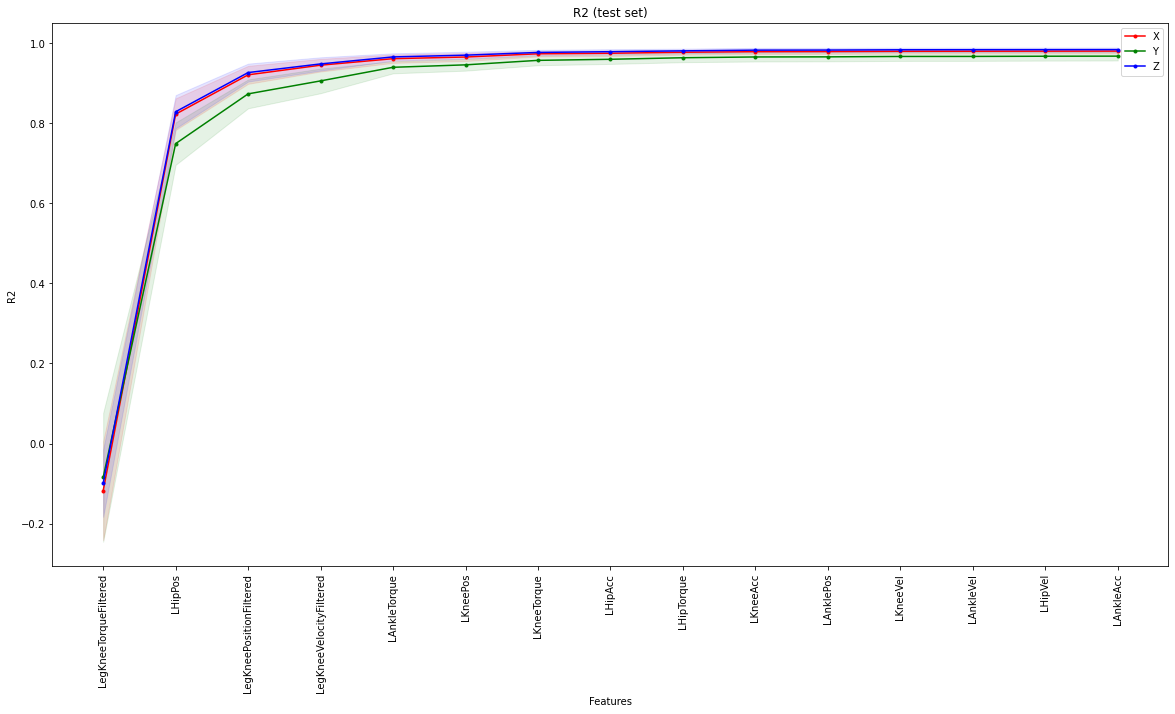

In [23]:
for score in ['MAE', 'MSE', 'R2']:
    # Confidence intervarl for each axis
    ci_x_sup = [mean + std for mean, std in zip(scores_dict['test'][score]['X_mean'], scores_dict['test'][score]['X_std'])]
    ci_x_inf = [mean - std for mean, std in zip(scores_dict['test'][score]['X_mean'], scores_dict['test'][score]['X_std'])]
    ci_y_sup = [mean + std for mean, std in zip(scores_dict['test'][score]['Y_mean'], scores_dict['test'][score]['Y_std'])]
    ci_y_inf = [mean - std for mean, std in zip(scores_dict['test'][score]['Y_mean'], scores_dict['test'][score]['Y_std'])]
    ci_z_sup = [mean + std for mean, std in zip(scores_dict['test'][score]['Z_mean'], scores_dict['test'][score]['Z_std'])]
    ci_z_inf = [mean - std for mean, std in zip(scores_dict['test'][score]['Z_mean'], scores_dict['test'][score]['Z_std'])]

    x_ax = range(len(feature_importances), 0, -1)
    plt.figure(figsize=(20,10))
    plt.plot(x_ax, scores_dict['test'][score]['X_mean'], color='r', marker='.', label='X')
    plt.fill_between(x_ax, ci_x_sup, ci_x_inf, color='r', alpha=0.1)
    plt.plot(x_ax, scores_dict['test'][score]['Y_mean'], color='g', marker='.', label='Y')
    plt.fill_between(x_ax, ci_y_sup, ci_y_inf, color='g', alpha=0.1)
    plt.plot(x_ax, scores_dict['test'][score]['Z_mean'], color='b', marker='.', label='Z')
    plt.fill_between(x_ax, ci_z_sup, ci_z_inf, color='b', alpha=0.1)
    plt.xticks(x_ax, feature_importances['feature'][::-1], rotation=90)
    plt.xlabel('Features')
    plt.ylabel(score)
    plt.title(score + ' (test set)')
    plt.legend()
    plt.show()

In [37]:
# Remove features in different pre-selected sets to visualize the impact in the scores
steps = {
    1: [],
    2: ['LegKneeTorqueFiltered'],
    3: ['LegKnee{}Filtered'.format(m) for m in ['Position', 'Velocity', 'Torque']],
    4: ['LegKnee{}Filtered'.format(m) for m in ['Position', 'Velocity', 'Torque']] + ['L{}{}'.format(a, m) for a in ['Hip', 'Knee', 'Ankle'] for m in ['Vel', 'Acc']]
}

scores_dict = {
        'train':{
            'MAE': {'X_mean': [], 'X_std': [], 'Y_mean': [], 'Y_std': [], 'Z_mean': [], 'Z_std': []},
            'MSE': {'X_mean': [], 'X_std': [], 'Y_mean': [], 'Y_std': [], 'Z_mean': [], 'Z_std': []},
            'R2': {'X_mean': [], 'X_std': [], 'Y_mean': [], 'Y_std': [], 'Z_mean': [], 'Z_std': []}
        },
        'test':{
            'MAE': {'X_mean': [], 'X_std': [], 'Y_mean': [], 'Y_std': [], 'Z_mean': [], 'Z_std': []},
            'MSE': {'X_mean': [], 'X_std': [], 'Y_mean': [], 'Y_std': [], 'Z_mean': [], 'Z_std': []},
            'R2': {'X_mean': [], 'X_std': [], 'Y_mean': [], 'Y_std': [], 'Z_mean': [], 'Z_std': []}
        }
    }

for key, excluded_features in tqdm(steps.items()):
    # Select the index of the features to use
    fi_idx = list(feature_importances.loc[~feature_importances['feature'].isin(excluded_features)].index)
    
    # Define and train the model
    model_fs = RandomForestRegressor(random_state=0, verbose=0)
    model_fs.fit(X_train[:, fi_idx], Y_train)
    
    # Predict the target for each subset and get its scores
    train_preds = model_fs.predict(X_train[:, fi_idx])
    test_preds = model_fs.predict(X_test[:, fi_idx])
    
    scores_dict = sum_up_scores(scores_dict, Y_train, train_preds, Y_test, test_preds, N_CELLS)
    
    del model_fs
    gc.collect()
    
# Save the scores
json.dump(scores_dict, open('./logs/scores_fs2_{}.json'.format(DATA_ID), 'w'))

100%|██████████| 4/4 [33:58<00:00, 509.55s/it]


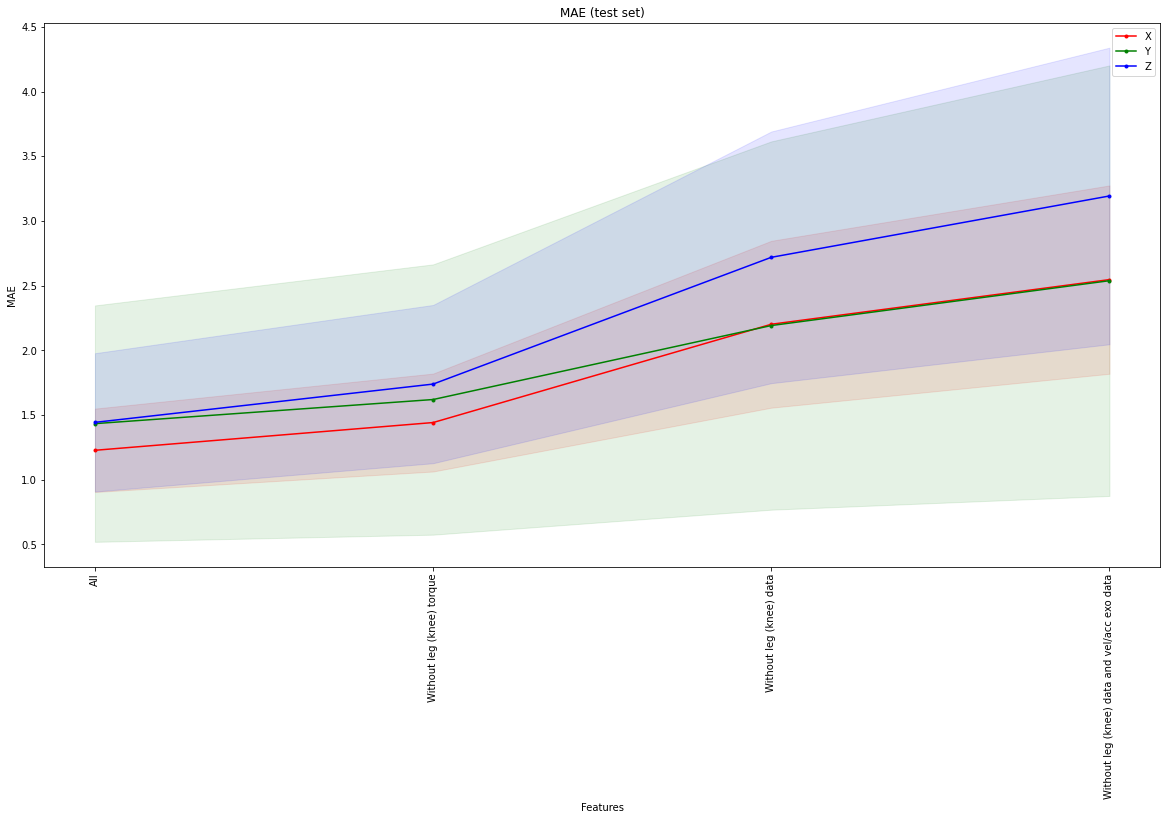

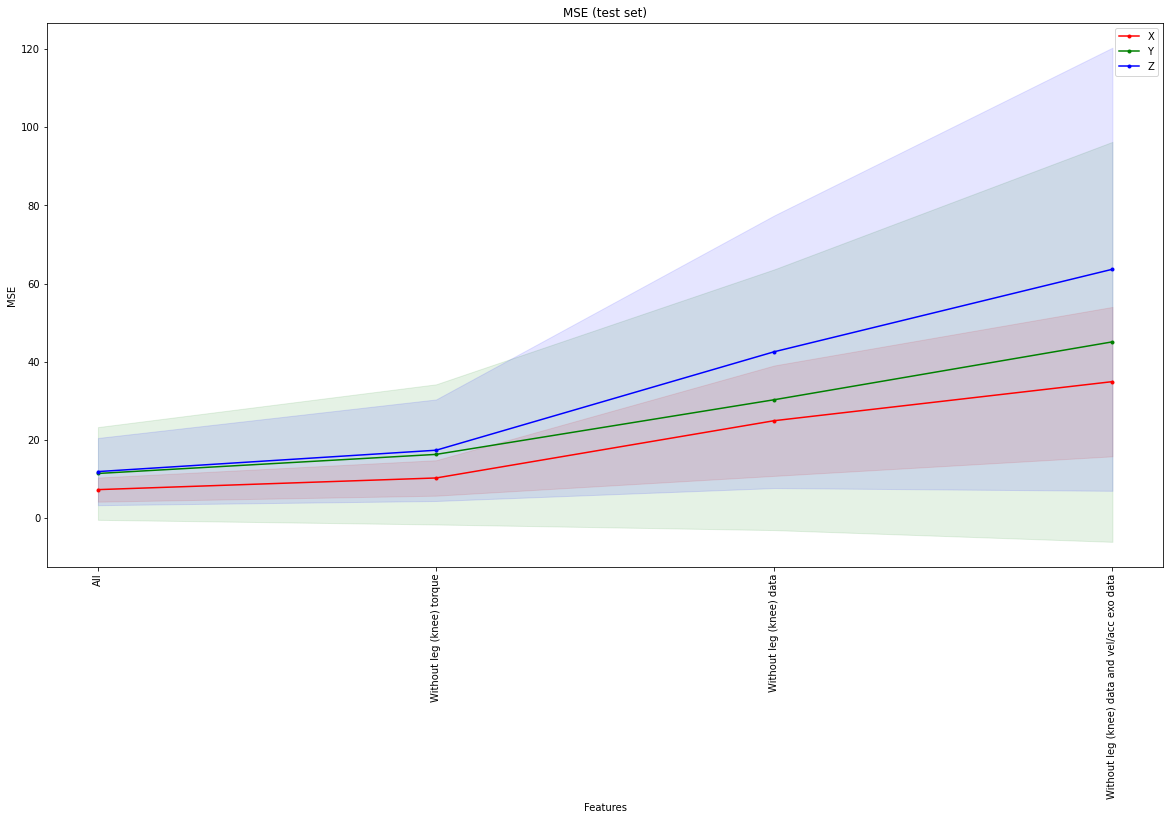

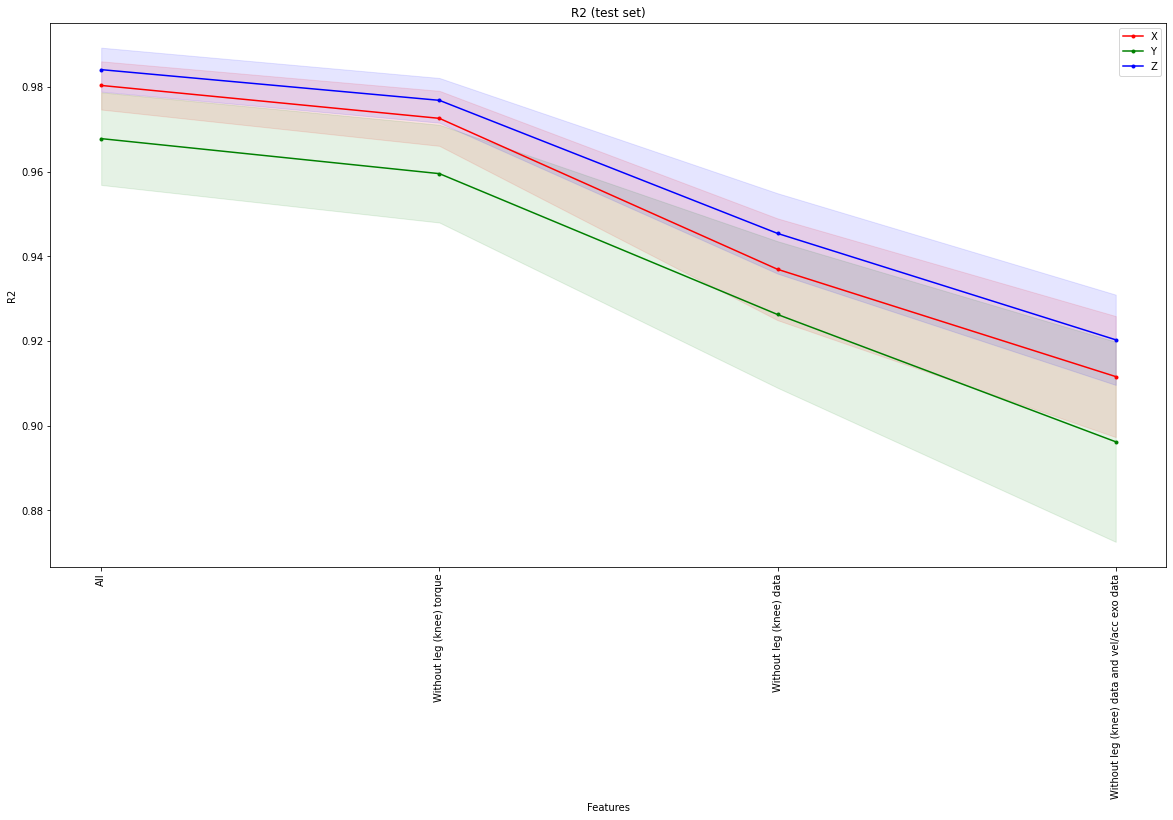

In [39]:
for score in ['MAE', 'MSE', 'R2']:
    # Confidence intervarl for each axis
    ci_x_sup = [mean + std for mean, std in zip(scores_dict['test'][score]['X_mean'], scores_dict['test'][score]['X_std'])]
    ci_x_inf = [mean - std for mean, std in zip(scores_dict['test'][score]['X_mean'], scores_dict['test'][score]['X_std'])]
    ci_y_sup = [mean + std for mean, std in zip(scores_dict['test'][score]['Y_mean'], scores_dict['test'][score]['Y_std'])]
    ci_y_inf = [mean - std for mean, std in zip(scores_dict['test'][score]['Y_mean'], scores_dict['test'][score]['Y_std'])]
    ci_z_sup = [mean + std for mean, std in zip(scores_dict['test'][score]['Z_mean'], scores_dict['test'][score]['Z_std'])]
    ci_z_inf = [mean - std for mean, std in zip(scores_dict['test'][score]['Z_mean'], scores_dict['test'][score]['Z_std'])]

    x_ax = range(len(steps))
    x_ax_ticks = ['All', 'Without leg (knee) torque', 'Without leg (knee) data', 'Without leg (knee) data and vel/acc exo data']
    plt.figure(figsize=(20,10))
    plt.plot(x_ax, scores_dict['test'][score]['X_mean'], color='r', marker='.', label='X')
    plt.fill_between(x_ax, ci_x_sup, ci_x_inf, color='r', alpha=0.1)
    plt.plot(x_ax, scores_dict['test'][score]['Y_mean'], color='g', marker='.', label='Y')
    plt.fill_between(x_ax, ci_y_sup, ci_y_inf, color='g', alpha=0.1)
    plt.plot(x_ax, scores_dict['test'][score]['Z_mean'], color='b', marker='.', label='Z')
    plt.fill_between(x_ax, ci_z_sup, ci_z_inf, color='b', alpha=0.1)
    plt.xticks(x_ax, x_ax_ticks, rotation=90)
    plt.xlabel('Features')
    plt.ylabel(score)
    plt.title(score + ' (test set)')
    plt.legend()
    plt.show()